<!-- sort_network MNIST -->

In [1]:
!pip install algovision


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader


class MultiDigitDataset(Dataset):

    def __init__(
            self,
            images,
            labels,
            num_digits,
            num_compare,
            seed=0,
            determinism=True,
    ):
        super(MultiDigitDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.num_digits = num_digits
        self.num_compare = num_compare
        self.seed = seed
        self.rand_state = None

        self.determinism = determinism

        if determinism:
            self.reset_rand_state()

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):

        if self.determinism:
            prev_state = torch.random.get_rng_state()
            torch.random.set_rng_state(self.rand_state)

        labels = []
        images = []
        labels_ = None
        for digit_idx in range(self.num_digits):
            id = torch.randint(len(self), (self.num_compare, ))
            labels.append(self.labels[id])
            images.append(self.images[id].type(torch.float32) / 255.)
            if labels_ is None:
                labels_ = torch.zeros_like(labels[0] * 1.)
            labels_ = labels_ + 10.**(self.num_digits - 1 - digit_idx) * self.labels[id]

        images = torch.cat(images, dim=-1)

        if self.determinism:
            self.rand_state = torch.random.get_rng_state()
            torch.random.set_rng_state(prev_state)

        return images, labels_

    def reset_rand_state(self):
        prev_state = torch.random.get_rng_state()
        torch.random.manual_seed(self.seed)
        self.rand_state = torch.random.get_rng_state()
        torch.random.set_rng_state(prev_state)

In [3]:
class MultiDigitSplits(object):
    def __init__(self, dataset, num_digits=4, num_compare=None, seed=0, deterministic_data_loader=True):
        
        self.deterministic_data_loader = deterministic_data_loader

        if dataset == 'mnist':
            # MNISTデータセットをロード
            trva_real = datasets.MNIST(root='./data-mnist', download=True)
            xtr_real = trva_real.data[:55000].view(-1, 1, 28, 28)
            ytr_real = trva_real.targets[:55000]
            xva_real = trva_real.data[55000:].view(-1, 1, 28, 28)
            yva_real = trva_real.targets[55000:]

            te_real = datasets.MNIST(root='./data-mnist', train=False, download=True)
            xte_real = te_real.data.view(-1, 1, 28, 28)
            yte_real = te_real.targets

            # MultiDigitDatasetを使ってデータセットを作成
            self.train_dataset = MultiDigitDataset(
                images=xtr_real, labels=ytr_real, num_digits=num_digits, num_compare=num_compare, seed=seed,
                determinism=deterministic_data_loader)
            self.valid_dataset = MultiDigitDataset(
                images=xva_real, labels=yva_real, num_digits=num_digits, num_compare=num_compare, seed=seed)
            self.test_dataset = MultiDigitDataset(
                images=xte_real, labels=yte_real, num_digits=num_digits, num_compare=num_compare, seed=seed)

        else:
            raise NotImplementedError(f"The dataset {dataset} is not implemented.")

    def get_train_loader(self, batch_size, **kwargs):
        # 訓練用データローダの作成
        train_loader = DataLoader(self.train_dataset,
                                  batch_size=batch_size,
                                  num_workers=4 if not self.deterministic_data_loader else 0,
                                  shuffle=True, **kwargs)
        return train_loader

    def get_valid_loader(self, batch_size, **kwargs):
        # 検証用データローダの作成
        valid_loader = DataLoader(self.valid_dataset,
                                  batch_size=batch_size, shuffle=False, **kwargs)
        return valid_loader

    def get_test_loader(self, batch_size, **kwargs):
        # テスト用データローダの作成
        test_loader = DataLoader(self.test_dataset,
                                 batch_size=batch_size, shuffle=False, **kwargs)
        return test_loader


In [4]:
import collections
import functools
import operator

# 複数の辞書を入力として受け取り、それらの平均を計算する
def avg_list_of_dicts(list_of_dicts):
    summed = functools.reduce(operator.add, map(collections.Counter, list_of_dicts))
    averaged = {k: summed[k] / len(list_of_dicts) for k in summed}
    return averaged

# データローダーから指定された数のサンプルを取り出して返す
def load_n(loader, n):
    i = 0
    while i < n:
        for x in loader:
            yield x
            i += 1
            if i == n:
                break

In [5]:
import torch
from torch import nn
import torch.nn.functional as F


class MultiDigitMNISTNet(nn.Module):
    # n_digits=1にすれば１桁MNIST
    def __init__(self, n_digits=4):
        super(MultiDigitMNISTNet, self).__init__()
        self.n_digits = n_digits
        self.conv1 = nn.Conv2d(1, 32, 5, 1, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.fc1 = nn.Linear(n_digits * 7 * 7 * 64, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x_shape = x.shape
        if len(x_shape) == 5:
            x = x.reshape(-1, *x_shape[2:])
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.n_digits * 7 * 7 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(*x_shape[:2], 1)
        return x

In [6]:
# ランキングの正確性の評価
def ranking_accuracy(data, targets):
    scores = model(data).squeeze(2)

    acc = torch.argsort(targets, dim=-1) == torch.argsort(scores, dim=-1)

    acc_em = acc.all(-1).float().mean()
    acc_ew = acc.float().mean()

    # acc_em:完全一致率，acc_ew:部分一致率，em5:上位５要素の一致率
    scores = scores[:, :5]
    targets = targets[:, :5]
    acc = torch.argsort(targets, dim=-1) == torch.argsort(scores, dim=-1)
    acc_em5 = acc.all(-1).float().mean()

    return dict(
        acc_em=acc_em.type(torch.float32).mean().item(),
        acc_ew=acc_ew.type(torch.float32).mean().item(),
        acc_em5=acc_em5.type(torch.float32).mean().item(),
    )

Training steps:   0%|          | 0/100000 [00:00<?, ?it/s]

199 valid {'acc_em': 0.27259999215602876, 'acc_ew': 0.6064400291442871, 'acc_em5': 0.27259999215602876}
399 valid {'acc_em': 0.29699999213218686, 'acc_ew': 0.6224400305747986, 'acc_em5': 0.29699999213218686}
599 valid {'acc_em': 0.3141999912261963, 'acc_ew': 0.6371200299263, 'acc_em5': 0.3141999912261963}
799 valid {'acc_em': 0.310199990272522, 'acc_ew': 0.636920028924942, 'acc_em5': 0.310199990272522}
999 valid {'acc_em': 0.32939999163150785, 'acc_ew': 0.6497200286388397, 'acc_em5': 0.32939999163150785}
1199 valid {'acc_em': 0.34659999191761015, 'acc_ew': 0.6606800329685211, 'acc_em5': 0.34659999191761015}
1399 valid {'acc_em': 0.34379999101161957, 'acc_ew': 0.6552400326728821, 'acc_em5': 0.34379999101161957}
1599 valid {'acc_em': 0.3431999930739403, 'acc_ew': 0.6578800284862518, 'acc_em5': 0.3431999930739403}
1799 valid {'acc_em': 0.35659999191761016, 'acc_ew': 0.6689200317859649, 'acc_em5': 0.35659999191761016}
1999 valid {'acc_em': 0.368799991607666, 'acc_ew': 0.6786800253391266, '

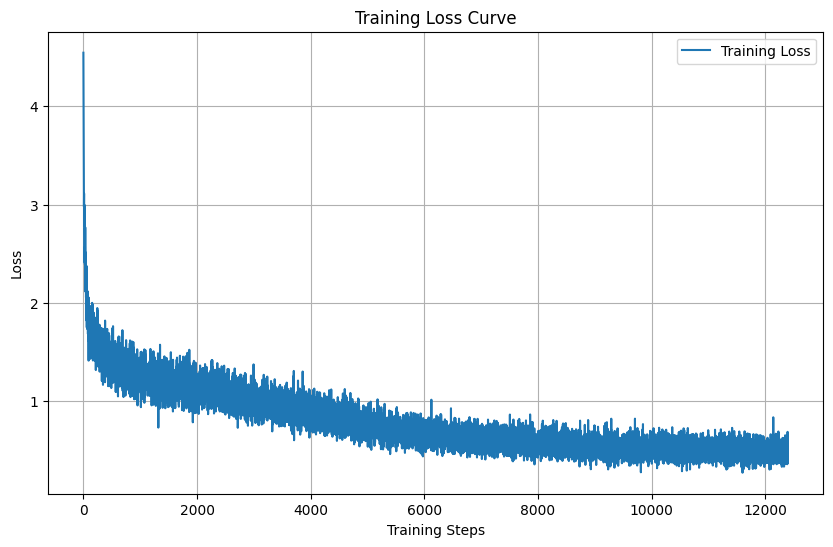

In [7]:
from tqdm.notebook import tqdm
import random
import torch
from algovision import (
    Algorithm, Input, Output, Variable, Var, VariableInt, VarInt,               # core
    Eq, NEq, LT, LEq, GT, GEq, CatProbEq, CosineSimilarity, IsTrue, IsFalse,    # conditions
    If, While, For,                                                             # control_structures
    Let, LetInt, Print, Min, ArgMin, Max, ArgMax,                               # functions
)

class Args:
    batch_size = 100
    num_compare = 5
    num_steps = 1_000_00
    eval_freq = 200
    method = 'loss_sum'
    beta = 8
    dataset = 'mnist'
    nloglr = 3.5
    device = 'cuda'
    seed = 0

args = Args()

random.seed(args.seed)
torch.manual_seed(args.seed)

best_valid_acc = 0.

# --- デバイス確認 ---
if args.device == 'cuda' and not torch.cuda.is_available():
    print('----------------------------------------------------')
    print('--- WARNING: No GPU detected, running on CPU ... ---')
    print('----------------------------------------------------')
    args.device = 'cpu'

# --- MNIST データセットの分割 ---
splits = MultiDigitSplits(dataset=args.dataset, num_compare=args.num_compare, seed=args.seed)

data_loader_train = splits.get_train_loader(args.batch_size, drop_last=True)
data_loader_valid = splits.get_valid_loader(args.batch_size, drop_last=True)
data_loader_test = splits.get_test_loader(args.batch_size, drop_last=True)

# --- MNIST モデルの定義 ---
model = MultiDigitMNISTNet().to(args.device)
model.train()
model.eval()
# --- オプティマイザの定義 ---
optim = torch.optim.Adam(model.parameters(), lr=10**(-args.nloglr))

# --- バブルソートアルゴリズムの定義 ---
bubble_sort = Algorithm(
    Input('array'),

    Var('a', torch.tensor(0.).to(args.device)),
    Var('b', torch.tensor(0.).to(args.device)),
    Var('swapped', torch.tensor(1.).to(args.device)),
    Var('loss_prod', torch.tensor(0.).to(args.device)),
    Var('loss_sum', torch.tensor(0.).to(args.device)),
    VarInt('j', 0),
    VarInt('n', lambda array: array.shape[1] - 1),
    While(IsTrue('swapped'),
        Let('swapped', 0),
        For('i', 'n',
            LetInt('j', lambda i: i + 1),
            Let('a', 'array', ['i']),
            Let('b', 'array', ['j']),
            If(GT('a', 'b'),
                if_true=[
                    Let('array', [lambda i: i + 1], 'a'),
                    Let('array', ['i'], 'b'),
                    Let('swapped', lambda swapped: 1.),
                    Let('loss_prod', 1.),
                    Let('loss_sum', lambda loss_sum: loss_sum + 1.),
                ]
            ),
        ),
        LetInt('n', lambda n: n - 1),
    ),
    Output('array'),
    Output('loss_prod'),
    Output('loss_sum'),
    beta=args.beta,
)

best_valid_acc = 0.0
patience = 5  # 改善しないエポック数（耐性）
patience_counter = 0

valid_accs = []
test_acc = None
train_losses = []

# --- トレーニングループ ---
for iter_idx, (data, targets) in tqdm(
    enumerate(load_n(data_loader_train, args.num_steps)),
    desc="Training steps",
    total=args.num_steps,
):
    data = data.to(args.device)
    targets = targets.to(args.device)

    # ターゲット順にデータを並び替え
    data_sorted = data[torch.arange(args.batch_size).to(args.device).unsqueeze(1), torch.argsort(targets, dim=-1)]

    # モデルの出力と損失計算
    outputs = model(data_sorted).squeeze(2)
    _, loss_prod, loss_sum = bubble_sort(outputs)

    # 損失選択とバックプロパゲーション
    if args.method == 'loss_sum':
        loss = loss_sum.mean()
    elif args.method == 'loss_prod':
        loss = loss_prod.mean()
    else:
        raise ValueError(args.method)
    
    train_losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()

    # 検証データでの精度計算
    if (iter_idx + 1) % args.eval_freq == 0:
        current_valid_accs = []
        for data, targets in data_loader_valid:
            data, targets = data.to(args.device), targets.to(args.device)
            current_valid_accs.append(ranking_accuracy(data, targets))
        valid_accs.append(avg_list_of_dicts(current_valid_accs))

        print(iter_idx, 'valid', valid_accs[-1])

        # アーリーストッピングのチェック
        if valid_accs[-1]['acc_em5'] > best_valid_acc:
            best_valid_acc = valid_accs[-1]['acc_em5']
            patience_counter = 0  # 改善があったのでカウンターをリセット
        else:
            patience_counter += 1

        # アーリーストッピングが発動した場合
        if patience_counter >= patience:
            print(f"Early stopping at step {iter_idx + 1}")
            break

print('final test', test_acc)

current_test_accs = []

# データローダーからデータを取得して精度を計算
for data, targets in data_loader_test:
    data, targets = data.to(args.device), targets.to(args.device)
    current_test_accs.append(ranking_accuracy(data, targets))

# テスト精度の平均化
if current_test_accs:
    test_acc = avg_list_of_dicts(current_test_accs)
else:
    test_acc = {'acc_em5': 0.0, 'acc_em10': 0.0}  # デフォルト値

# 結果を出力
print('Final test accuracy:', test_acc)


# --- 学習曲線のプロット ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()
